# Nb-20180312-1920-RandomForest-GainPrediction

This is a modification of the previous notebook.

Do a simple random forest to try to predict if a stock sticker will make a gain the next day.

Looked like EMA was useful, lets add some more EMA values...

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from collections import defaultdict
import operator

In [3]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [4]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [5]:
import finance as fat

In [6]:
# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 10.0]

In [7]:
ticker = 'IBM'

In [8]:
data = fat.get_price_data(ticker)
ohlcv = data

Loaded data for IBM: 1970-01-02 to 2018-03-12.


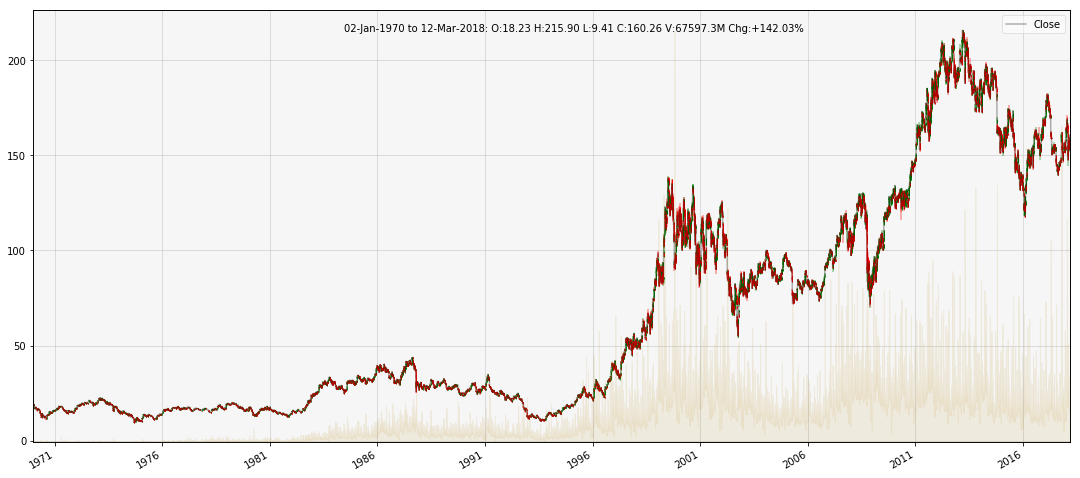

In [9]:
fat.plot_daily_ticker(ohlcv)

In [45]:
# Just use 'Adj Close'
data = pd.DataFrame(data, columns=['Adj Close'])
data.head()

,Adj Close
Date,
1970-01-09,1.709291
1970-01-12,1.703502
1970-01-13,1.733032
1970-01-14,1.731295
1970-01-15,1.767195


Get table with prices for last 5 days, and price for following day.

In [46]:
for i in range(-5, 0, 1) :
    data[f'Adj Close {i}d'] = data['Adj Close'].shift(-i)
data = data.dropna()
data.head()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d
Date,,,,,,
1970-01-16,1.712765,1.709291,1.703502,1.733032,1.731295,1.767195
1970-01-19,1.621280,1.703502,1.733032,1.731295,1.767195,1.712765
1970-01-20,1.651388,1.733032,1.731295,1.767195,1.712765,1.621280
1970-01-21,1.644440,1.731295,1.767195,1.712765,1.621280,1.651388
1970-01-22,1.649072,1.767195,1.712765,1.621280,1.651388,1.644440


In [47]:
# SMA: 6, 12, 20, 200
data = fat.add_sma_columns(data, 'Adj Close', [6,12,20,200])
data.tail()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close SMA20,Adj Close SMA200
Date,,,,,,,,,,
2018-03-06,155.720001,156.550003,155.830002,153.809998,154.490005,156.949997,155.558334,155.494167,154.106273,149.179685
2018-03-07,158.320007,155.830002,153.809998,154.490005,156.949997,155.720001,155.853335,155.672502,154.331000,149.234030
2018-03-08,156.210007,153.809998,154.490005,156.949997,155.720001,158.320007,155.916669,155.760002,154.524000,149.274624
2018-03-09,159.309998,154.490005,156.949997,155.720001,158.320007,156.210007,156.833336,156.205835,155.110000,149.333676
2018-03-12,160.259995,156.949997,155.720001,158.320007,156.210007,159.309998,157.795001,156.795835,155.647500,149.395151


In [48]:
data = fat.add_ema_columns(data, 'Adj Close', [3,6,9,12,16,20,26,35,50])
data.tail()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close SMA20,Adj Close SMA200,Adj Close EMA3,Adj Close EMA6,Adj Close EMA9,Adj Close EMA12,Adj Close EMA16,Adj Close EMA20,Adj Close EMA26,Adj Close EMA35,Adj Close EMA50
Date,,,,,,,,,,,,,,,,,,,
2018-03-06,155.720001,156.550003,155.830002,153.809998,154.490005,156.949997,155.558334,155.494167,154.106273,149.179685,155.785176,155.633803,155.506757,155.457021,155.521130,155.655275,155.845234,155.958839,155.723728
2018-03-07,158.320007,155.830002,153.809998,154.490005,156.949997,155.720001,155.853335,155.672502,154.331000,149.234030,157.052591,156.401290,156.069407,155.897481,155.850410,155.909059,156.028551,156.090015,155.825543
2018-03-08,156.210007,153.809998,154.490005,156.949997,155.720001,158.320007,155.916669,155.760002,154.524000,149.274624,156.631299,156.346637,156.097527,155.945562,155.892715,155.937720,156.041992,156.096681,155.840620
2018-03-09,159.309998,154.490005,156.949997,155.720001,158.320007,156.210007,156.833336,156.205835,155.110000,149.333676,157.970649,157.193312,156.740021,156.463167,156.294748,156.258890,156.284067,156.275199,155.976674
2018-03-12,160.259995,156.949997,155.720001,158.320007,156.210007,159.309998,157.795001,156.795835,155.647500,149.395151,159.115322,158.069507,157.444016,157.047295,156.761248,156.639947,156.578580,156.496576,156.144648


In [49]:
data = fat.add_bollinger_bands(data, 'Adj Close')
data.tail()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close SMA20,Adj Close SMA200,...,Adj Close EMA6,Adj Close EMA9,Adj Close EMA12,Adj Close EMA16,Adj Close EMA20,Adj Close EMA26,Adj Close EMA35,Adj Close EMA50,Adj Close BBandHi20,Adj Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-06,155.720001,156.550003,155.830002,153.809998,154.490005,156.949997,155.558334,155.494167,154.106273,149.179685,...,155.633803,155.506757,155.457021,155.521130,155.655275,155.845234,155.958839,155.723728,159.487779,148.724767
2018-03-07,158.320007,155.830002,153.809998,154.490005,156.949997,155.720001,155.853335,155.672502,154.331000,149.234030,...,156.401290,156.069407,155.897481,155.850410,155.909059,156.028551,156.090015,155.825543,160.029191,148.632809
2018-03-08,156.210007,153.809998,154.490005,156.949997,155.720001,158.320007,155.916669,155.760002,154.524000,149.274624,...,156.346637,156.097527,155.945562,155.892715,155.937720,156.041992,156.096681,155.840620,160.201118,148.846882
2018-03-09,159.309998,154.490005,156.949997,155.720001,158.320007,156.210007,156.833336,156.205835,155.110000,149.333676,...,157.193312,156.740021,156.463167,156.294748,156.258890,156.284067,156.275199,155.976674,160.158154,150.061846
2018-03-12,160.259995,156.949997,155.720001,158.320007,156.210007,159.309998,157.795001,156.795835,155.647500,149.395151,...,158.069507,157.444016,157.047295,156.761248,156.639947,156.578580,156.496576,156.144648,160.469219,150.825781


In [50]:
scaled = data.div(data['Adj Close'], axis=0)
scaled.head()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close SMA20,Adj Close SMA200,...,Adj Close EMA6,Adj Close EMA9,Adj Close EMA12,Adj Close EMA16,Adj Close EMA20,Adj Close EMA26,Adj Close EMA35,Adj Close EMA50,Adj Close BBandHi20,Adj Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-16,1.0,0.997972,0.994592,1.011833,1.010819,1.031779,NaN,NaN,NaN,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN
1970-01-19,1.0,1.050714,1.068928,1.067857,1.090000,1.056428,NaN,NaN,NaN,NaN,...,1.023512,1.025079,1.025863,1.026450,1.026803,1.027129,1.027408,1.027650,NaN,NaN
1970-01-20,1.0,1.049440,1.048388,1.070127,1.037167,0.981768,NaN,NaN,NaN,NaN,...,1.002670,1.003771,1.004365,1.004829,1.005115,1.005383,1.005617,1.005823,NaN,NaN
1970-01-21,1.0,1.052817,1.074649,1.041549,0.985916,1.004225,NaN,NaN,NaN,NaN,...,1.004239,1.005298,1.005891,1.006364,1.006659,1.006939,1.007184,1.007401,NaN,NaN
1970-01-22,1.0,1.071630,1.038624,0.983147,1.001404,0.997191,NaN,NaN,NaN,NaN,...,1.000920,1.001738,1.002233,1.002643,1.002905,1.003157,1.003382,1.003583,NaN,NaN


In [51]:
scaled = scaled.dropna()
scaled.head()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close SMA20,Adj Close SMA200,...,Adj Close EMA6,Adj Close EMA9,Adj Close EMA12,Adj Close EMA16,Adj Close EMA20,Adj Close EMA26,Adj Close EMA35,Adj Close EMA50,Adj Close BBandHi20,Adj Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,,,
1970-10-28,1.0,0.974283,0.971332,0.994941,0.977235,0.981450,0.983207,0.981450,0.993676,0.978226,...,0.986287,0.985254,0.984786,0.983352,0.980692,0.975104,0.965502,0.951599,1.036202,0.951150
1970-10-29,1.0,0.964824,0.988275,0.970686,0.974874,0.993299,0.981993,0.976689,0.987269,0.970532,...,0.985485,0.982921,0.981543,0.979497,0.976586,0.970898,0.961308,0.947372,1.029769,0.944770
1970-10-30,1.0,0.999368,0.981582,0.985817,1.004449,1.011225,0.997073,0.988693,0.997663,0.980549,...,0.997533,0.995164,0.993705,0.991610,0.988734,0.983145,0.973649,0.959653,1.040037,0.955289
1970-11-02,1.0,0.962753,0.966906,0.985181,0.991827,0.980817,0.981247,0.971931,0.977563,0.960868,...,0.984570,0.980859,0.978544,0.975813,0.972646,0.966931,0.957473,0.943549,1.015924,0.939202
1970-11-03,1.0,0.978743,0.997241,1.003969,0.992824,1.012242,0.997503,0.985670,0.987881,0.971713,...,0.997588,0.994293,0.991981,0.989199,0.986024,0.980341,0.970906,0.956861,1.021378,0.954385


In [52]:
scaled['Gain +1d'] = scaled['Adj Close -1d'].shift(-1) < 1.0
scaled.head()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close SMA20,Adj Close SMA200,...,Adj Close EMA9,Adj Close EMA12,Adj Close EMA16,Adj Close EMA20,Adj Close EMA26,Adj Close EMA35,Adj Close EMA50,Adj Close BBandHi20,Adj Close BBandLo20,Gain +1d
Date,,,,,,,,,,,,,,,,,,,,,
1970-10-28,1.0,0.974283,0.971332,0.994941,0.977235,0.981450,0.983207,0.981450,0.993676,0.978226,...,0.985254,0.984786,0.983352,0.980692,0.975104,0.965502,0.951599,1.036202,0.951150,True
1970-10-29,1.0,0.964824,0.988275,0.970686,0.974874,0.993299,0.981993,0.976689,0.987269,0.970532,...,0.982921,0.981543,0.979497,0.976586,0.970898,0.961308,0.947372,1.029769,0.944770,False
1970-10-30,1.0,0.999368,0.981582,0.985817,1.004449,1.011225,0.997073,0.988693,0.997663,0.980549,...,0.995164,0.993705,0.991610,0.988734,0.983145,0.973649,0.959653,1.040037,0.955289,True
1970-11-02,1.0,0.962753,0.966906,0.985181,0.991827,0.980817,0.981247,0.971931,0.977563,0.960868,...,0.980859,0.978544,0.975813,0.972646,0.966931,0.957473,0.943549,1.015924,0.939202,False
1970-11-03,1.0,0.978743,0.997241,1.003969,0.992824,1.012242,0.997503,0.985670,0.987881,0.971713,...,0.994293,0.991981,0.989199,0.986024,0.980341,0.970906,0.956861,1.021378,0.954385,True


In [53]:
del scaled['Adj Close']
scaled.head()

,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close SMA20,Adj Close SMA200,Adj Close EMA3,...,Adj Close EMA9,Adj Close EMA12,Adj Close EMA16,Adj Close EMA20,Adj Close EMA26,Adj Close EMA35,Adj Close EMA50,Adj Close BBandHi20,Adj Close BBandLo20,Gain +1d
Date,,,,,,,,,,,,,,,,,,,,,
1970-10-28,0.974283,0.971332,0.994941,0.977235,0.981450,0.983207,0.981450,0.993676,0.978226,0.990540,...,0.985254,0.984786,0.983352,0.980692,0.975104,0.965502,0.951599,1.036202,0.951150,True
1970-10-29,0.964824,0.988275,0.970686,0.974874,0.993299,0.981993,0.976689,0.987269,0.970532,0.991951,...,0.982921,0.981543,0.979497,0.976586,0.970898,0.961308,0.947372,1.029769,0.944770,False
1970-10-30,0.999368,0.981582,0.985817,1.004449,1.011225,0.997073,0.988693,0.997663,0.980549,1.001543,...,0.995164,0.993705,0.991610,0.988734,0.983145,0.973649,0.959653,1.040037,0.955289,True
1970-11-02,0.962753,0.966906,0.985181,0.991827,0.980817,0.981247,0.971931,0.977563,0.960868,0.991165,...,0.980859,0.978544,0.975813,0.972646,0.966931,0.957473,0.943549,1.015924,0.939202,False
1970-11-03,0.978743,0.997241,1.003969,0.992824,1.012242,0.997503,0.985670,0.987881,0.971713,1.001650,...,0.994293,0.991981,0.989199,0.986024,0.980341,0.970906,0.956861,1.021378,0.954385,True


### Initial processing

In [54]:
scaled = scaled.reset_index()
scaled.head()

,Date,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close SMA20,Adj Close SMA200,...,Adj Close EMA9,Adj Close EMA12,Adj Close EMA16,Adj Close EMA20,Adj Close EMA26,Adj Close EMA35,Adj Close EMA50,Adj Close BBandHi20,Adj Close BBandLo20,Gain +1d
0,1970-10-28,0.974283,0.971332,0.994941,0.977235,0.981450,0.983207,0.981450,0.993676,0.978226,...,0.985254,0.984786,0.983352,0.980692,0.975104,0.965502,0.951599,1.036202,0.951150,True
1,1970-10-29,0.964824,0.988275,0.970686,0.974874,0.993299,0.981993,0.976689,0.987269,0.970532,...,0.982921,0.981543,0.979497,0.976586,0.970898,0.961308,0.947372,1.029769,0.944770,False
2,1970-10-30,0.999368,0.981582,0.985817,1.004449,1.011225,0.997073,0.988693,0.997663,0.980549,...,0.995164,0.993705,0.991610,0.988734,0.983145,0.973649,0.959653,1.040037,0.955289,True
3,1970-11-02,0.962753,0.966906,0.985181,0.991827,0.980817,0.981247,0.971931,0.977563,0.960868,...,0.980859,0.978544,0.975813,0.972646,0.966931,0.957473,0.943549,1.015924,0.939202,False
4,1970-11-03,0.978743,0.997241,1.003969,0.992824,1.012242,0.997503,0.985670,0.987881,0.971713,...,0.994293,0.991981,0.989199,0.986024,0.980341,0.970906,0.956861,1.021378,0.954385,True


In [55]:
add_datepart(scaled, 'Date')
scaled.head()

,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close SMA20,Adj Close SMA200,Adj Close EMA3,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0.974283,0.971332,0.994941,0.977235,0.981450,0.983207,0.981450,0.993676,0.978226,0.990540,...,28,2,301,False,False,False,False,False,False,25920000
1,0.964824,0.988275,0.970686,0.974874,0.993299,0.981993,0.976689,0.987269,0.970532,0.991951,...,29,3,302,False,False,False,False,False,False,26006400
2,0.999368,0.981582,0.985817,1.004449,1.011225,0.997073,0.988693,0.997663,0.980549,1.001543,...,30,4,303,False,False,False,False,False,False,26092800
3,0.962753,0.966906,0.985181,0.991827,0.980817,0.981247,0.971931,0.977563,0.960868,0.991165,...,2,0,306,False,False,False,False,False,False,26352000
4,0.978743,0.997241,1.003969,0.992824,1.012242,0.997503,0.985670,0.987881,0.971713,1.001650,...,3,1,307,False,False,False,False,False,False,26438400


The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [56]:
scaled.tail().T

,11944,11945,11946,11947,11948
Adj Close -5d,1.00533,0.984272,0.984636,0.969745,0.979346
Adj Close -4d,1.00071,0.971513,0.988989,0.985186,0.971671
Adj Close -3d,0.987734,0.975808,1.00474,0.977465,0.987895
Adj Close -2d,0.992101,0.991347,0.996863,0.993786,0.974729
Adj Close -1d,1.0079,0.983578,1.01351,0.980541,0.994072
Adj Close SMA6,0.998962,0.98442,0.998122,0.984454,0.984619
Adj Close SMA12,0.99855,0.983278,0.997119,0.980515,0.978384
Adj Close SMA20,0.989637,0.974804,0.989207,0.973636,0.971219
Adj Close SMA200,0.958,0.94261,0.955602,0.937378,0.932205
Adj Close EMA3,1.00042,0.991995,1.0027,0.991593,0.992857


In [57]:
train_cats(scaled)

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [59]:
stamp = "20180312-1920"
file_name = f'data/tmp/{ticker}-{stamp}-gain-raw'

In [60]:
os.makedirs('data/tmp', exist_ok=True)
scaled.to_feather(file_name)

### Pre-processing

In the future we can simply read it from this fast format.

In [61]:
df_raw = pd.read_feather(file_name)

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [62]:
dep_col = 'Gain +1d'

In [63]:
df, y, nas = proc_df(df_raw, dep_col)

In [64]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [65]:
len(df_raw)

11949

In [66]:
n_valid = int(len(df_raw)*.2)  # 20% of samples 
n_trn = len(df_raw)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((9560, 33), (9560,), (2389, 33))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [67]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Single tree

In [68]:
m = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1, random_state=42)
m.fit(X_train, y_train)
print_score(m)

[0.5296025104602511, 0.49225617413143574]


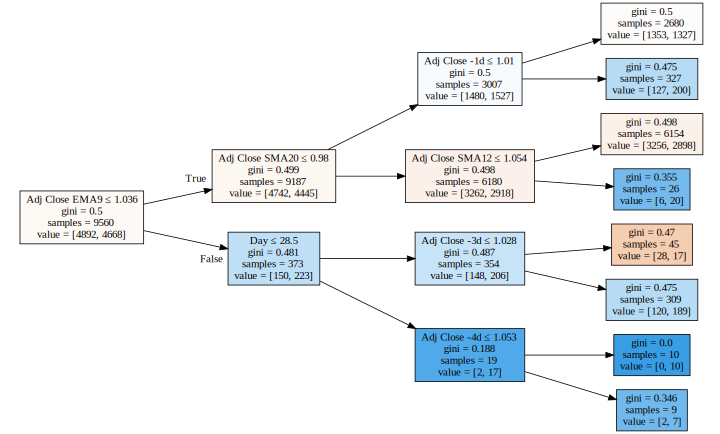

In [69]:
draw_tree(m.estimators_[0], raw_train, precision=3)

In [70]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[1124,   45],
       [1168,   52]], dtype=int64)

## Bagging

In [71]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=20, max_features='sqrt', n_jobs=-1, oob_score=True, random_state=42)
m.fit(X_train, y_train)
print_score(m)

[0.825, 0.509836751778987, 0.5219665271966527]


In [72]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[556, 613],
       [558, 662]], dtype=int64)

In [73]:
metrics.accuracy_score(y_valid, y_pred)

0.509836751778987

In [74]:
metrics.precision_score(y_valid, y_pred)

0.5192156862745098

In [75]:
metrics.recall_score(y_valid, y_pred)

0.5426229508196722

In [76]:
metrics.f1_score(y_valid, y_pred)

0.5306613226452905

In [77]:
# Percent of true gains over all samples: compare to precision -- precision should be signficantly higher if this is a useful
# prediction
# (cnf_matrix[1,0] + cnf_matrix[1,1]) / cnf_matrix.sum() 
cnf_matrix[1:].sum() / cnf_matrix.sum()

0.5106739221431561

In [90]:
fi = rf_feat_importance(m, df)

In [91]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

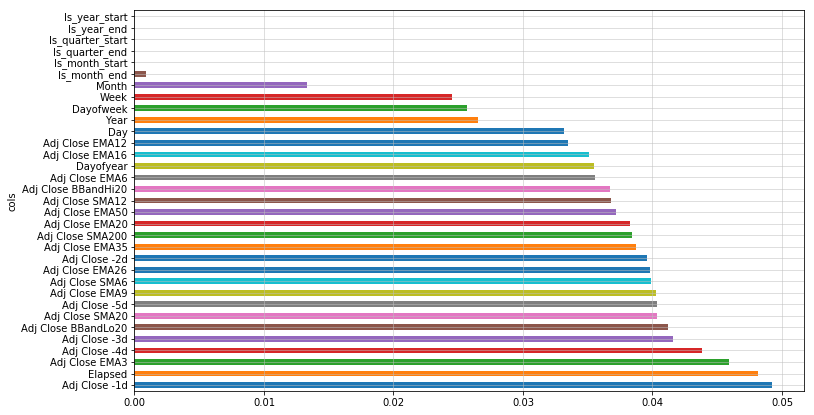

In [92]:
plot_fi(fi)